# Setup

In [13]:
import pandas as pd
import networkx as nx

In [2]:
users_df = pd.read_excel(r'./data/userdata.xlsx')
network_df = pd.read_excel(r'./data/network.xlsx')

In [5]:
users_df.head(10)

,user,listed,followers
0,SportChic_,0,137
1,HumbleAttitude1,28,3422
2,kjerbellis,0,11
3,InfogolApp,511,32357
4,DukeDFS,48,2363
5,the12gameparlay,0,5
6,b0br0vsky,0,126
7,lookn4aFULLRIDE,3,3406
8,Mateusz74968284,0,0
9,perilofafrica,17,1070


In [6]:
network_df.head(10)

,Source,Sourceid,Target,Targetid,type_of_content
0,ArijitFan1,1355121831372615683,ArijitFan1,1355121831372615683,Tweet
1,USMNTCORNER,1172274702049583105,USMNTCORNER,1172274702049583105,Tweet
2,ber2reh,1207348737258987520,Benzema,1964571728,Retweet
3,KB9_GOAT,1339101169042518017,Benzema,1964571728,Retweet
4,HfutbolW,1274615075723268097,HfutbolW,1274615075723268097,Tweet
5,miles__69,1181660258118389760,Royaltycfc,1050069385094811648,Retweet
6,JudyLazo,410740338,nclarkrd,103933553,Retweet
7,BanglaMostbet,1287653327082315777,BanglaMostbet,1287653327082315777,Tweet
8,FootAggregator,1204015945422909445,Genting_Bet,4201010939,Retweet
9,FootAggregator,1204015945422909445,GuillemBalague,26759984,Retweet


In [8]:
network_df.rename(columns={'Source': 'source', 'Sourceid': 'source_id', 'Target': 'target',
                          'Targetid': 'target_id'}, inplace=True)

In [9]:
network_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   source           5816 non-null   object
 1   source_id        5816 non-null   int64 
 2   target           5816 non-null   object
 3   target_id        5816 non-null   int64 
 4   type_of_content  5816 non-null   object
dtypes: int64(2), object(3)
memory usage: 227.3+ KB


In [10]:
network_df['type_of_content'].value_counts()

Retweet    4475
Tweet       905
Mention     353
Reply        83
Name: type_of_content, dtype: int64

In [11]:
network_df['type_of_content'].replace(['Retweet', 'Mention', 'Reply'], 'Non-Tweet', inplace=True)

In [12]:
network_df['type_of_content'].value_counts()

Non-Tweet    4911
Tweet         905
Name: type_of_content, dtype: int64

In [14]:
network_df.head(10)

,source,source_id,target,target_id,type_of_content
0,ArijitFan1,1355121831372615683,ArijitFan1,1355121831372615683,Tweet
1,USMNTCORNER,1172274702049583105,USMNTCORNER,1172274702049583105,Tweet
2,ber2reh,1207348737258987520,Benzema,1964571728,Non-Tweet
3,KB9_GOAT,1339101169042518017,Benzema,1964571728,Non-Tweet
4,HfutbolW,1274615075723268097,HfutbolW,1274615075723268097,Tweet
5,miles__69,1181660258118389760,Royaltycfc,1050069385094811648,Non-Tweet
6,JudyLazo,410740338,nclarkrd,103933553,Non-Tweet
7,BanglaMostbet,1287653327082315777,BanglaMostbet,1287653327082315777,Tweet
8,FootAggregator,1204015945422909445,Genting_Bet,4201010939,Non-Tweet
9,FootAggregator,1204015945422909445,GuillemBalague,26759984,Non-Tweet


In [32]:
non_tweet_df = network_df[network_df['type_of_content'] == 'Non-Tweet']
tweet_df = network_df[network_df['type_of_content'] == 'Tweet']

In [ ]:
# Calculate number of tweets

# Graph

In [19]:
G = nx.DiGraph()

edges = list()
for (a,b) in zip(non_tweet_df['source'], non_tweet_df['target']):
    edges.append((a,b))

G.add_edges_from(edges)
G

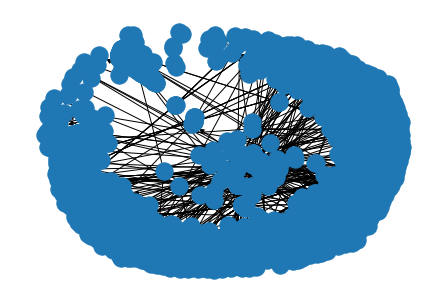

In [20]:
nx.draw(G)

In [22]:
degree_centrality=pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index').reset_index()
degree_centrality

,index,0
0,ber2reh,0.000232
1,Benzema,0.641746
2,KB9_GOAT,0.000232
3,miles__69,0.000232
4,Royaltycfc,0.009984
...,...,...
4303,Sidneyyyyy__,0.000232
4304,adityatrd,0.000232
4305,santiagos83,0.000232
4306,brtop7,0.000232


In [21]:
closeness_centrality=pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index').reset_index()
closeness_centrality

,index,0
0,ber2reh,0.000000
1,Benzema,0.641746
2,KB9_GOAT,0.000000
3,miles__69,0.000000
4,Royaltycfc,0.009519
...,...,...
4303,Sidneyyyyy__,0.000000
4304,adityatrd,0.000000
4305,santiagos83,0.000000
4306,brtop7,0.000000


In [23]:
betweenness_centrality=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index').reset_index()
betweenness_centrality

,index,0
0,ber2reh,0.0
1,Benzema,0.0
2,KB9_GOAT,0.0
3,miles__69,0.0
4,Royaltycfc,0.0
...,...,...
4303,Sidneyyyyy__,0.0
4304,adityatrd,0.0
4305,santiagos83,0.0
4306,brtop7,0.0


In [24]:
network_measures = degree_centrality.merge(closeness_centrality, on='index').merge(betweenness_centrality, on='index')
network_measures

,index,0_x,0_y,0
0,ber2reh,0.000232,0.000000,0.0
1,Benzema,0.641746,0.641746,0.0
2,KB9_GOAT,0.000232,0.000000,0.0
3,miles__69,0.000232,0.000000,0.0
4,Royaltycfc,0.009984,0.009519,0.0
...,...,...,...,...
4303,Sidneyyyyy__,0.000232,0.000000,0.0
4304,adityatrd,0.000232,0.000000,0.0
4305,santiagos83,0.000232,0.000000,0.0
4306,brtop7,0.000232,0.000000,0.0


In [28]:
network_measures.columns = ['user', 'degree', 'closeness', 'betweenness']

In [30]:
network_measures = network_measures.merge(users_df, on='user')
network_measures

,user,degree,closeness,betweenness,listed,followers
0,ber2reh,0.000232,0.000000,0.0,0,41
1,Benzema,0.641746,0.641746,0.0,5247,12130878
2,KB9_GOAT,0.000232,0.000000,0.0,0,3
3,miles__69,0.000232,0.000000,0.0,0,4879
4,Royaltycfc,0.009984,0.009519,0.0,6,4623
...,...,...,...,...,...,...
4302,Sidneyyyyy__,0.000232,0.000000,0.0,0,78
4303,adityatrd,0.000232,0.000000,0.0,4,513
4304,santiagos83,0.000232,0.000000,0.0,10,882
4305,brtop7,0.000232,0.000000,0.0,1,76


In [31]:
network_measures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4307 entries, 0 to 4306
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user         4307 non-null   object 
 1   degree       4307 non-null   float64
 2   closeness    4307 non-null   float64
 3   betweenness  4307 non-null   float64
 4   listed       4307 non-null   int64  
 5   followers    4307 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 235.5+ KB
